# Semantic segmentation using Poutyne




Semantic segmentation refers to the process of linking each pixel in an image 
to a class label. We can think of semantic segmentation as image classification at a pixel level. The image below clarifies the defintion of semantic segmentation.
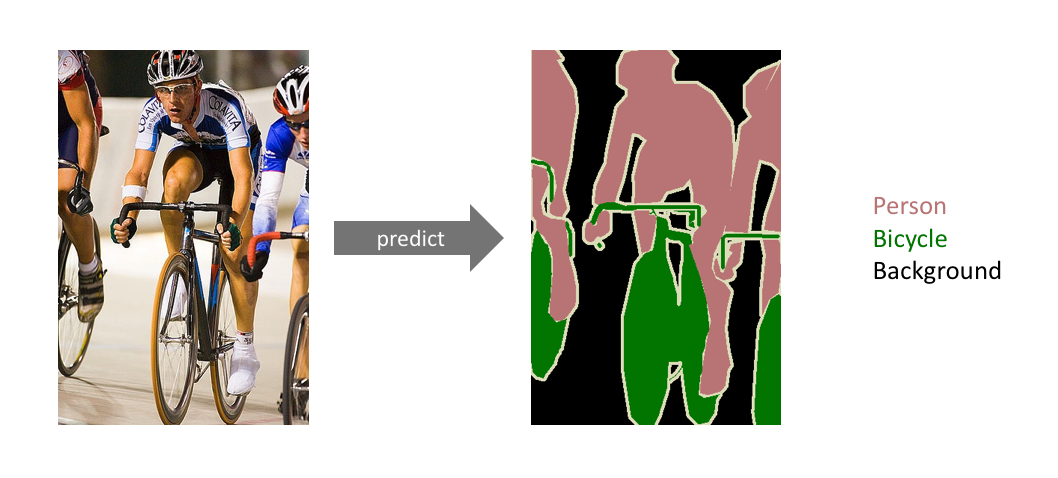

In this example, we are going to use and train a convolutional Unet, inorder to design a network for semantic segmentation .We download and use the VOCSegmentation 2007 dataset for this purpose. This dataset can be easily downloaded from `torchvision.datasets`. 

In [1]:
%pip install poutyne    # to install the Poutyne library

     |████████████████████████████████| 133kB 16.8MB/s 


Unet (the network we use in this example) is a convolutional neural network, similar to the convolutional autoencoders. However, Unet take advantage of shortcuts between encoder (contraction path) and decoder (expanding path), which helps it handle the vanishing gradient problem. In the following sections, we are going to install and import the `segmentation-models-pytorch` library, which contains different architectures of Unet.

In [2]:
%pip install segmentation-models-pytorch 

     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 245kB 36.6MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=fd728c47cbea43bd2d4889723b68af0ae9eebd0c22419b968f897cb936581d15
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=36901c22e65ad20fb00b5b7ea748be142dabb437b27b9135b00723c89851a498
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch


Let’s import all the needed packages.

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import math
import os
import segmentation_models_pytorch as smp
import PIL
import cv2


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset


import torchvision
import torchvision.models as models
import torchvision.transforms as tfms
import torchvision.datasets as datasets
from torchvision.utils import  make_grid, save_image

from poutyne import Model, ModelCheckpoint, CSVLogger


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The current processor is ...', device)


The current processor is ... cuda


# Training constants

In [4]:
learning_rate = 0.001
batch_size = 32
image_size = 224
num_epochs = 30
val_split_rate = 0.2

_mean = [0.485, 0.456, 0.406]  # mean of the imagenet dataset for normalizing 
_std = [0.229, 0.224, 0.225]  # std of the imagenet dataset for normalizing 


#Load the data

In [5]:
if not os.path.exists('dataset'): os.mkdir('dataset')   # making a directory to download and save the dataset.

transform = tfms.Compose([
    tfms.Resize((image_size, image_size)),  
    tfms.ToTensor(),        
    tfms.Normalize(_mean, _std)
])

trn_dataset = torchvision.datasets.VOCSegmentation('./dataset/', year='2007', download=True, image_set='train', transform=transform)
val_dataset = torchvision.datasets.VOCSegmentation('./dataset/', year='2007', download=True, image_set='val', transform=transform)

Using downloaded and verified file: ./dataset/VOCtrainval_06-Nov-2007.tar


The VOCSegmentation dataset, downoladed above, contatins images and their segmentation map. However, these are offered as a PIL format and in different sizes. The transformations applied by the "`torchvision.transforms`" resizes all the images to the tensor of the size (224, 224). However, the target image (the PIL segmentation map) should also be resized to a tensor with the same size. The function below applies the needed changes and provides the final datasets. 

In [6]:

class mydataset(Dataset):       
        
    
        def __init__(self, dataset):
            self.dataset = dataset
            
        
        def __getitem__(self, index):
            
            input_image = self.dataset[index][0]
            
            target_image = cv2.resize(np.array(self.dataset[index][1].convert("L")), (224,224)).astype('float32')
            target_image = torch.tensor(target_image).unsqueeze(0)
            
            return input_image, target_image
        def __len__(self):
            
            return len(self.dataset)   


And finally we generate the dataset and dataloader, proper for the application:

In [7]:
trn_dataset_new = mydataset(trn_dataset)
val_dataset_new = mydataset(val_dataset)

trn_dataloader = DataLoader(trn_dataset_new, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset_new, batch_size=batch_size, shuffle=False)

A random batch of training dataset is shown below:

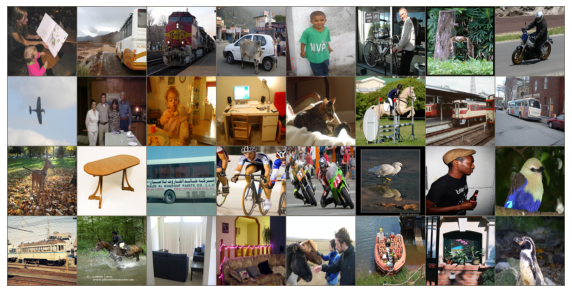

In [8]:
samples = next(iter(trn_dataloader))
inputs = samples[0]
input_grid = make_grid(inputs)

fig = plt.figure(figsize=(10, 10))
input_grid = input_grid.numpy()
input_grid = input_grid.transpose((1, 2, 0)) * _std + _mean
inp = np.clip(input_grid, 0, 1)
plt.imshow(inp)
plt.axis('off')
plt.show()

Here, you can also see the ground-truth (segmentation map) for the image grid shown above.

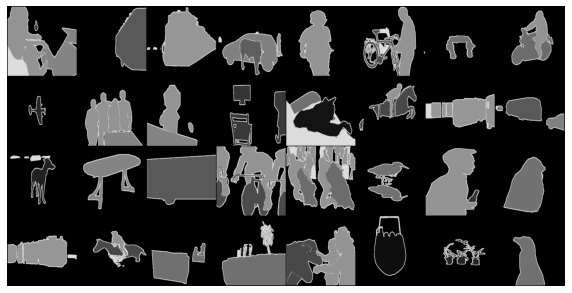

In [9]:
ground_truth = samples[1]
input_grid = make_grid(ground_truth)

fig = plt.figure(figsize=(10, 10))
inp = input_grid.numpy().transpose((1, 2, 0))

plt.imshow(np.uint8(inp))
plt.axis('off')
plt.show()

In [10]:
# specifying loss function
criterion = nn.MSELoss()

# specifying the network
network = smp.Unet('resnet34', encoder_weights='imagenet')

# specifying optimizer
optimizer = optim.Adam (network.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


We can see the architecture of the Res34-Unet below. As noticed in the section above, this network is imported from the `segmentation-models-pytorch` library, which contains many other architectures as well. You can import and use other available networks, trying to increase the accuracy.

In [11]:
network

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Training of deep neural networks is a challenging task, specially when we deal with a data with big size or number. There are numerous factors and hyperparameters, which play an important role in the success of the network. One of these determining factors is the epoch number. Right number of the epochs would help your network to be trained well, however the lower and higher numbers would make your network underfitted or overfitted, respectively. With some data (such as images or videos), it is very time consuming to repeat the training for different numbers of epochs, to find the best one. Poutyne library has provided some amazing tools to address this problem. As you would notice in the following sections, by the use of callbacks, you would be able to record and retrive the best parameters (weights) through your ratherly big number of epochs, without needing to repeat the training again and again. Moreover, Poutyne also gives you the possibility to resume your training, from the last done epoch, if you feel the need for even more iterartions.

In [12]:
#callbacks

save_path = 'saves'

# Creating saving directory 
os.makedirs(save_path, exist_ok=True)

callbacks = [
# Save the latest weights to be able to continue the optimization at the end for more epochs.
ModelCheckpoint(os.path.join(save_path, 'last_weights.ckpt')),

# Save the weights in a new file when the current model is better than all previous models.
ModelCheckpoint(os.path.join(save_path, 'best_weight.ckpt'),
                save_best_only=True, restore_best=True, verbose=True),

# Save the losses for each epoch in a TSV.
CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

In [13]:
# Poutyne Model on GPU
model = Model(network, optimizer, criterion, device=device)

# Train
model.fit_generator(trn_dataloader, val_dataloader, epochs=num_epochs, callbacks=callbacks, progress_options={'coloring': False})

Epoch:  1/30 Train steps: 7 Val steps: 7 8.35s loss: 5689.550097 val_loss: 22775.110466
Epoch 1: val_loss improved from inf to 22775.11047, saving file to saves/best_weight.ckpt
Epoch:  2/30 Train steps: 7 Val steps: 7 8.32s loss: 5592.538191 val_loss: 3783.661693
Epoch 2: val_loss improved from 22775.11047 to 3783.66169, saving file to saves/best_weight.ckpt
Epoch:  3/30 Train steps: 7 Val steps: 7 8.48s loss: 5512.981803 val_loss: 4833.620727
Epoch:  4/30 Train steps: 7 Val steps: 7 8.45s loss: 5434.901741 val_loss: 4234.191579
Epoch:  5/30 Train steps: 7 Val steps: 7 8.36s loss: 5357.463078 val_loss: 4879.060040
Epoch:  6/30 Train steps: 7 Val steps: 7 8.34s loss: 5280.042765 val_loss: 4793.592161
Epoch:  7/30 Train steps: 7 Val steps: 7 8.51s loss: 5180.716084 val_loss: 4807.303748
Epoch:  8/30 Train steps: 7 Val steps: 7 8.43s loss: 5083.682570 val_loss: 4702.940565
Epoch:  9/30 Train steps: 7 Val steps: 7 8.37s loss: 4974.939105 val_loss: 4506.498265
Epoch: 10/30 Train steps: 7 V

[{'epoch': 1,
  'loss': 5689.55009672174,
  'time': 8.350342186999967,
  'val_loss': 22775.110466182512},
 {'epoch': 2,
  'loss': 5592.538191069827,
  'time': 8.318105044999982,
  'val_loss': 3783.6616933043574},
 {'epoch': 3,
  'loss': 5512.981802762411,
  'time': 8.47971662499998,
  'val_loss': 4833.620726965963},
 {'epoch': 4,
  'loss': 5434.901740991328,
  'time': 8.446382094,
  'val_loss': 4234.191579326218},
 {'epoch': 5,
  'loss': 5357.463077526914,
  'time': 8.360529722000024,
  'val_loss': 4879.060040254548},
 {'epoch': 6,
  'loss': 5280.042765494169,
  'time': 8.336309183999958,
  'val_loss': 4793.592161366637},
 {'epoch': 7,
  'loss': 5180.716084311453,
  'time': 8.50567946199999,
  'val_loss': 4807.303747615903},
 {'epoch': 8,
  'loss': 5083.682570462021,
  'time': 8.431445361000044,
  'val_loss': 4702.940564939114},
 {'epoch': 9,
  'loss': 4974.939105020186,
  'time': 8.369920934999982,
  'val_loss': 4506.4982646530225},
 {'epoch': 10,
  'loss': 4853.487837357955,
  'time'

# Calculation of the scores and visualization of results

There is one more suprising facility in poutyne, which make the evulation task more easy and straight forward. Usually, computer vision reserachers try to evaluate their trained networks with validation/test dataset, having the score (accuracy or loss usually), ground_truth and claculated results simoultaneously. The `evaluate` function in Poutyne, not only provides you with the score, but also have made the other two items ready for further analysis and visualization. In the next few codes, you will see the examples. 

In [14]:
loss, predictions, ground_truth = model.evaluate_generator(val_dataloader, return_pred=True, return_ground_truth=True)

Test steps: 7 3.56s test_loss: 3199.258815                               


We show some of the segmentation results in the image below (gary scale):

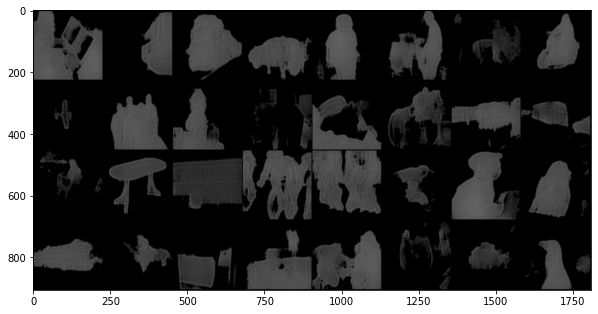

In [15]:
outputs = torch.tensor(model.predict_on_batch(inputs))

output_grid = make_grid(outputs)
fig = plt.figure(figsize=(10, 10))
out = output_grid.numpy().transpose((1, 2, 0))
plt.imshow(np.uint8(out))
plt.show()

based on the result visualization, we decide to resume training for more epochs.

In [ ]:
# Train
model.fit_generator(trn_dataloader, val_dataloader, epochs=70, callbacks=callbacks, initial_epoch=num_epochs)

In [17]:
loss, predictions, ground_truth = model.evaluate_generator(val_dataloader, return_pred=True, return_ground_truth=True)

Test steps: 7 3.48s test_loss: 2985.748121                               


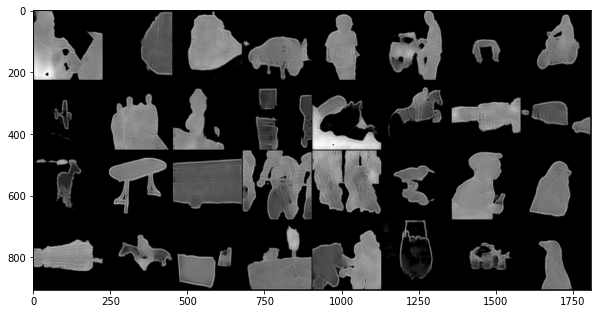

In [18]:
outputs = torch.tensor(model.predict_on_batch(inputs))

output_grid = make_grid(outputs)
fig = plt.figure(figsize=(10, 10))
out = output_grid.numpy().transpose((1, 2, 0))
plt.imshow(np.uint8(out))
plt.show()

To show results in color:

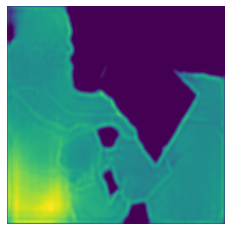

In [23]:
output_sample = outputs[0][0].numpy()
plt.axis('off')
plt.imshow(output_sample)
plt.show()

# Last note

This example shows you how to simply design and train your own segmentation network, however to get better results you can play with hyper parameters and do further finetuning to increase the accuracy.